In [57]:
#General imports
import copy
import os  
import pandas as pd  
import matplotlib.pyplot as plt
import numpy as np  
import re
import seaborn as sb
import sys 
from tqdm import tqdm
from typing import Callable, List, Dict, Tuple, Set

#sklearn and tensorflow imports
from sklearn.metrics import f1_score
from tensorflow.keras.layers import Bidirectional,  Dense, Dropout, Embedding, GRU, Input, LSTM, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.random import set_seed

In [2]:
#fixed seeds to get reproducible results
np.random.seed(42)
set_seed(42)

#Bulding the dataframe

## Dataset download and extraction

In [3]:
import urllib.request  #  download files
import zipfile  #  unzip files

DATASET_NAME = "dataset.zip"
DATASET_FOLDERNAME = "Dataset"
DATASET_SUBFOLDER = "dependency_treebank/"
SPLIT_DISTRIBUTION = [100, 150, 199]

working_folder = os.getcwd()

print("Current working directory: " + str(working_folder))

dataset_folder = os.path.join(os.getcwd(), DATASET_FOLDERNAME)

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

url = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'

dataset_path = os.path.join(dataset_folder, "dataset.zip")

if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(url, dataset_path)
    print("Successful download")

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_folder)
    print("Successful extraction")

#update folder to the extracted one
dataset_folder = os.path.join(dataset_folder, DATASET_SUBFOLDER)

Current working directory: /content
Successful download
Successful extraction


In [4]:
print(dataset_folder)

/content/Dataset/dependency_treebank/


## Dataframe construction

In [5]:
def encode_dataset(dataset_folder: str, 
                   split_dist: list(), ) -> Dict[str,pd.DataFrame]:
    
    df_dict = {"train": pd.DataFrame(columns=['sentence', 'labels']),
                "val": pd.DataFrame(columns=['sentence', 'labels']),
                "test":pd.DataFrame(columns=['sentence', 'labels'])}
    split = ""

    for filename in sorted(os.listdir(dataset_folder)):
        file_path = os.path.join(dataset_folder, filename)
        try:
            if os.path.isfile(file_path):
                with open(file_path, mode='r', encoding='utf-8') as text_file:
                    # read it and extract 
                    document_number = filename.split("_")[1].split(".")[0]
                    if int(document_number) <= split_dist[0]:
                        split = "train"
                    elif split_dist[0] < int(document_number) <= split_dist[1]:
                        split = "val"
                    else:
                        split = "test"

                    df_file = pd.read_table(
                        file_path, 
                        delimiter='\t', 
                        names=['word', 'label'], 
                        usecols=[0,1],
                        skip_blank_lines=False)
                    
                    #splitting file content in sentences
                    idx = list(df_file.loc[df_file.isnull()['word']].index)
                    idx.append(len(df_file))
                    prev = 0
                    for sep in idx:
                        df_sentence = pd.DataFrame({
                            'sentence': [df_file['word'][prev:sep].to_list()], 
                            'labels': [df_file['label'][prev:sep].to_list()]})
                        df_dict[split] = pd.concat([df_dict[split], df_sentence], ignore_index=True)
                        prev = sep + 1
                    
        except Exception as e:
            print('Failed to process %s. Reason: %s' % (file_path, e))
            sys.exit(0)

    return df_dict

In [6]:
df_dict = encode_dataset(dataset_folder, SPLIT_DISTRIBUTION)

In [7]:
df_dict["train"].head()

,sentence,labels
0,"[Pierre, Vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ..."
1,"[Mr., Vinken, is, chairman, of, Elsevier, N.V....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ..."
2,"[Rudolph, Agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP..."
3,"[A, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS..."
4,"[The, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V..."


In [8]:
df_dict["val"].head()

,sentence,labels
0,"[A, House-Senate, conference, approved, major,...","[DT, NNP, NN, VBD, JJ, NNS, IN, DT, NN, IN, JJ..."
1,"[For, the, Agency, for, International, Develop...","[IN, DT, NNP, IN, NNP, NNP, ,, NNS, VBD, $, CD..."
2,"[The, conference, approved, at, least, $, 55, ...","[DT, NN, VBD, IN, JJS, $, CD, CD, IN, JJ, NN, ..."
3,"[The, agreement, on, Poland, contrasts, with, ...","[DT, NN, IN, NNP, VBZ, IN, DT, JJ, NNS, VBG, I..."
4,"[These, fiscal, pressures, are, also, a, facto...","[DT, JJ, NNS, VBP, RB, DT, NN, IN, VBG, DT, NN..."


In [9]:
df_dict["test"].head()

,sentence,labels
0,"[Intelogic, Trace, Inc., ,, San, Antonio, ,, T...","[NNP, NNP, NNP, ,, NNP, NNP, ,, NNP, ,, VBD, P..."
1,"[The, move, boosts, Intelogic, Chairman, Asher...","[DT, NN, VBZ, NNP, NNP, NNP, NNP, POS, NN, TO,..."
2,"[Mr., Ackerman, already, is, seeking, to, oust...","[NNP, NNP, RB, VBZ, VBG, TO, VB, NNP, NNP, IN,..."
3,"[The, action, followed, by, one, day, an, Inte...","[DT, NN, VBN, IN, CD, NN, DT, NNP, NN, IN, PRP..."
4,"[In, New, York, Stock, Exchange, composite, tr...","[IN, NNP, NNP, NNP, NNP, JJ, NN, NN, ,, NNP, N..."


In [10]:
x = {"train": df_dict['train']['sentence'],
     "val": df_dict['val']['sentence'],
     "test": df_dict['test']['sentence']}

y = {"train": df_dict['train']['labels'],
     "val": df_dict['val']['labels'],
     "test": df_dict['test']['labels']}

# Glove Embedding model, vocabulary and OOV detection

## Load Glove embedding

In [11]:
import gensim
import gensim.downloader as gloader

def load_GloVe_embedding(embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model

In [12]:
EMBEDDING_DIMENSION = 50
glove_emb_model = load_GloVe_embedding(EMBEDDING_DIMENSION)

[==================================================] 100.0% 66.0/66.0MB downloaded


##Creating initial vocabulary

In [13]:
from collections import OrderedDict

def build_vocabulary(sr: pd.Series) -> List[str]:
    """
    Given a dataset, builds the corresponding word vocabulary.

    :param df: dataset from which we want to build the word vocabulary (pandas.DataFrame)
    :return:
      - vocabulary: set of unique terms that build up the vocabulary
    """
    vocabulary = []
    for sentence in tqdm(sr):
        for token in sentence:
            if token not in vocabulary:
                vocabulary.append(token)

    return vocabulary

In [14]:
vocabulary_dict = {}
for split in df_dict.keys():
    vocabulary_dict[split] = build_vocabulary(x[split])
    print()
    print(f'[Debug] {split} vocabulary size: {len(vocabulary_dict[split])}')

100%|██████████| 1963/1963 [00:00<00:00, 2087.37it/s]



[Debug] train vocabulary size: 8009


100%|██████████| 1299/1299 [00:00<00:00, 2581.99it/s]



[Debug] val vocabulary size: 5892


100%|██████████| 652/652 [00:00<00:00, 4056.31it/s]


[Debug] test vocabulary size: 3623


## OOV detection

In [15]:
def check_OOV_terms(vocabulary: List[str],
                    word_listing: List[str]):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """
    embedding_vocabulary = set(vocabulary)
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

In [16]:
OOV1 = check_OOV_terms(glove_emb_model.vocab.keys(), vocabulary_dict["train"])
OOV1_percentage = float(len(OOV1)) * 100 / len(vocabulary_dict["train"])
print(f"Total OOV terms: {len(OOV1)} ({OOV1_percentage:.2f}%)")

Total OOV terms: 2346 (29.29%)


A lot of words are OOV simply because they start with capital letter, so we will lower all the words and check again the OOV. Before this section we can insert a graph showing the OOV words

In [17]:
OOV1_lowercase = check_OOV_terms(glove_emb_model.vocab.keys(), [v.lower() for v in vocabulary_dict["train"]])
OOV1_lowercase_percentage = float(len(OOV1_lowercase)) * 100 / len(vocabulary_dict["train"])
print(f"Total OOV terms: {len(OOV1_lowercase)} ({OOV1_lowercase_percentage:.2f}%)")

Total OOV terms: 359 (4.48%)


In [18]:
print("\n".join(OOV1_lowercase))

737.5
415.8
pramual
custom-chip
akerfeldt
95,142
money-market
twindam
3\/4
money-fund
two-sevenths
12,252
post-hearing
recession-inspired
school-research
meinders
2,303,328
capital-gains
382-37
macheski
antitrust-law
mehrens
100,980
derel
glenham
234.4
stock-manipulation
bridgestone\/firestone
ensrud
times-stock
pattenden
roof-crush
2645.90
chemplus
social-studies
flightiness
moleculon
1.457
374.19
investor-relations
456.64
index-arbitrage
re-thought
unfair-trade
revenue-desperate
circuit-breaker
superpremiums
more-efficient
autions
4.898
centerbank
subminimum
38.375
mortgage-based
ac-130u
purepac
dollar-yen
374.20
-rrb-
durable-goods
bumkins
landonne
three-sevenths
wheel-loader
lap-shoulder
271,124
16,072
home-market
chilver
trading-company
ariail
lezovich
macmillan\/mcgraw-hill
forest-products
415.6
cray-3
computer-system-design
automotive-parts
4,393,237
wine-buying
kalipharma
37-a-share
cotran
buttoned-down
top-yielding
foreign-stock
ntg
test-prep
1\/4
tissue-transplant
beer-belly


# Preprocessing

Here we replace bracket value with their symbols: 
```
  -lrb- and -lcb-   -->  ( 
  -rrb- and -rcb-   -->  )
```

In addition, all the rational numbers will be replaced with the placeholder #number#, as long as the floating point numbers.
Note that rational numbers, instead of being like 3/4, are written as 3\/4. The cause is that symbol "/" is represented using "\/", as this happens also in other words that are notrational ones






In [19]:
def preprocessing(content_list: List[str]) -> List[str]:
    placeholder = "#number#"
    re_slashes = re.compile('\\\/')  #pattern \/ 
    re_rational = re.compile('\d+\/\d+')  #pattern rational number (e.g. 1/5)
    re_number = re.compile('[+-]?(\d*[.])\d+')  #pattern decimal number (e.g. 3.14)
    re_left_bracket = re.compile('(-lrb-)|(-lcb-)')  #pattern left bracket
    re_right_bracket = re.compile('(-rrb-)|(-rcb-)')  #pattern right bracket
    re_slashed_words = re.compile("(\w*)\/(\w*)")  #a slash separating words will be replaced with a dash, following the trend of the dataset, where composed words are in the form word-word

    content_list_preprocessed = [content.lower() for content in content_list]
    content_list_preprocessed = [re_slashes.sub("/", content) for content in content_list_preprocessed]
    content_list_preprocessed = [re_left_bracket.sub("(", content) for content in content_list_preprocessed]
    content_list_preprocessed = [re_right_bracket.sub(")", content) for content in content_list_preprocessed]
    content_list_preprocessed = [placeholder if re.match(re_rational, content) else content for content in content_list_preprocessed]
    content_list_preprocessed = [placeholder if re.match(re_number, content) else content for content in content_list_preprocessed]
    content_list_preprocessed = [content.replace("/", "-") if re.match(re_slashed_words, content) else content for content in content_list_preprocessed]

    return content_list_preprocessed


Preprocessing the training dataset

In [20]:
x_train_preprocessed = x["train"].apply(preprocessing)

Building the new vocabulary after preprocessing

In [21]:
train_vocabulary_preprocessed = build_vocabulary(x_train_preprocessed)
print()
print(f'[Debug] train vocabulary size after preprocessing: {len(train_vocabulary_preprocessed)}')

OOV1_preprocessed = check_OOV_terms(glove_emb_model.vocab.keys(), train_vocabulary_preprocessed)
OOV1_preprocessed_percentage = float(len(OOV1_preprocessed)) * 100 / len(train_vocabulary_preprocessed)
print(f"Total OOV terms: {len(OOV1_preprocessed)} ({OOV1_preprocessed_percentage:.2f}%)")

100%|██████████| 1963/1963 [00:00<00:00, 2256.74it/s]


[Debug] train vocabulary size after preprocessing: 7214
Total OOV terms: 318 (4.41%)


It can be seen that the number of OOV words has plummetted with respect to the the non preprocessed data. Similarly to train data, we apply preprocessing to validation and test splits.

In [22]:
x_pre = {"train": x_train_preprocessed,
        "val": x["val"].apply(preprocessing),
        "test": x["test"].apply(preprocessing)}

# Vocabulary creation and mapping
Since we want to work with numerical data only, we will mapp words and pos (labels) to numbers. 

In [23]:
# Methods to create mapping

#adds oov words at the end of vocabulary
def extend_vocabulary(word_to_idx_original: Dict[str, int],
                      words_to_add) -> Tuple[Dict[str, int],Dict[int, str]]:
  """
    Given mapping between word and indeces, adds new words.

    :param word_to_idx_original: dictionary with key=word and value=index to which the word is mapped
    :return:
      - word_to_idx_extended: word_to_idx with new words
      - idx_to_word_extended: swapped version of word_to_idx_extended (keys and values are swapped)
  """
  word_to_idx_extended = copy.deepcopy(word_to_idx_original)  #deep copy is needed, otherwise python does not create a copy but only a reference to the already existing object, thus reflecting changes on both
  idx = len(word_to_idx_extended.keys())
  if idx == 0: 
    idx = 1  #position 0 is reserved

  for sentence in words_to_add:
      for token in sentence:
          if token not in word_to_idx_extended:
              word_to_idx_extended[token] = idx 
              idx += 1
  idx_to_word_extended = {v: k for k, v in word_to_idx_extended.items()}

  return word_to_idx_extended, idx_to_word_extended

def encode_into_numbers(sentences: List[str],
                        word_to_idx_mapping: Dict[str, int]) -> List[int]:
    """
    Return a list of sequences encoded into integers following the mapping of the vocabulary
    """
    encoded_data = [[word_to_idx_mapping[token] for token in sentence] for sentence in sentences]
 
    return encoded_data

def decode_into_words(encoded_sentences: List[str],
                        idx_to_word_mapping: Dict[int,str]) -> List[str]:
    """
    Return a list of sequences decoded back to words following the (reverse) mapping of the vocabulary
    """
    decoded_data = [[idx_to_word_mapping[index] for index in sentence] for sentence in encoded_sentences]
 
    return decoded_data


Encoding the words

In [24]:
#creating vocabulary mapping for the words in the data set
#Note that they are incremental, this means that the val vocabulary includes the rain one, and the test one inlcudes train and val ones
#This has been made according to the guidelines on the construction of V1, V2, V3, V4. 
#All in all, the complete vocabulary is the one with _test suffix
#In the embedding section the intermediate vocabularies will be used according to what they contain. For example, to compute the embedding matrix on the train set, we will use word_to_idx_train, while for validation word_to_idx_val
word_to_idx_train, idx_to_word_train = extend_vocabulary({}, [glove_emb_model.vocab.keys()] + x_pre["train"].tolist())
print("Train vocabulary size: ", len(word_to_idx_train))
word_to_idx_val, idx_to_word_val = extend_vocabulary(word_to_idx_train, x_pre["val"].tolist())
print("Val vocabulary size: ", len(word_to_idx_val))
word_to_idx_test, idx_to_word_test = extend_vocabulary(word_to_idx_val, x_pre["test"].tolist())
print("Test vocabulary size: ", len(word_to_idx_test))

#encoding the data set

x_enc = {"train": encode_into_numbers(x_pre["train"].tolist(), word_to_idx_train),
        "val": encode_into_numbers(x_pre["val"].tolist(), word_to_idx_val),
        "test": encode_into_numbers(x_pre["test"].tolist(), word_to_idx_test)}


Train vocabulary size:  400318
Val vocabulary size:  400475
Test vocabulary size:  400571


Encoding the labels (pos)

In [25]:
#creating vocabulary mapping for the labels in the whole dataset
label_to_idx, idx_to_label = extend_vocabulary({},  y["train"].tolist() + y["val"].tolist() + y["test"].tolist())

y_enc = {"train": encode_into_numbers(y["train"].tolist(), label_to_idx),
        "val": encode_into_numbers(y["val"].tolist(), label_to_idx),
        "test": encode_into_numbers(y["test"].tolist(), label_to_idx)}

number_pos = len(label_to_idx)
print(f"In the dataset there are {number_pos} distinct POS")

In the dataset there are 45 distinct POS


In [26]:
print(x_enc["train"][0])
print(decode_into_words([x_enc["train"][0]], idx_to_word_test))
print(df_dict["train"]["sentence"].iloc[0])

[5030, 400001, 2, 4979, 83, 168, 2, 44, 1430, 1, 535, 20, 8, 128565, 370, 2344, 1264, 3]
[['pierre', 'vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov.', '29', '.']]
['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']


In [27]:
print(decode_into_words([y_enc["train"][0]], idx_to_label))
print(df_dict["train"]["labels"].iloc[0])
print(y_enc["train"][0])

[['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']]
['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']
[1, 1, 2, 3, 4, 5, 2, 6, 7, 8, 9, 10, 8, 5, 9, 1, 3, 11]


# Embedding matrix

In [28]:
def get_dashed_embeddings(embedding_model, word):
  if "-" in word:
    words_split = word.split("-")
    words_split.sort(key=len)  #getting the encoding of compound words starting from the longest one
    for word_piece in words_split:
      try:
        return embedding_model[word]  #if a word is found, assign its embedding to the matrix element
      except:
        pass  #if a word is not found, do nothing
  return None

def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx: Dict[str, int]) -> np.ndarray:
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param embedding_dimension: 

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """
    embedding_matrix = np.zeros((len(word_to_idx)+1, embedding_dimension), dtype=np.float32)
    
    #adding all GloVe vocabularies embeddings
    for word, idx in tqdm(word_to_idx.items()):
      if word in embedding_model:
          embedding_matrix[idx] = embedding_model[word]
      else: 
          dashed_embedding = get_dashed_embeddings(embedding_model, word)
          if dashed_embedding is None: #it means that word has no dash or all its subwords are oov
              dashed_embedding = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)
          embedding_matrix[idx] = dashed_embedding
 
    return embedding_matrix


#This functions adds the embedding of OOV words to the embedding matrix. Note tht it directly tries to find an embedding for dashed words and if none is retrieved it uses a uniform random distribution
def extend_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                            embedding_matrix: np.ndarray,
                            word_to_idx: Dict[str, int]) -> np.ndarray:

    oov_terms = [key for key, idx in word_to_idx.items() if idx >= embedding_matrix.shape[0]] #all the terms with mapped to an index gretaer than the vocabulary size (number of rows) are not in the embedding matrix 
    oov_embedding_matrix = np.zeros((len(oov_terms), embedding_matrix.shape[1]), dtype=np.float32)
    
    for idx, oov in enumerate(oov_terms):
        dashed_embedding = get_dashed_embeddings(embedding_model, oov)
        if dashed_embedding is None: #it means that word has no dash or all its subwords are oov
            dashed_embedding = np.random.uniform(low=-0.05, high=0.05, size=embedding_matrix.shape[1])

        oov_embedding_matrix[idx] = dashed_embedding

    return np.concatenate([embedding_matrix, oov_embedding_matrix], axis=0)

In [29]:
embedding_matrix = build_embedding_matrix(glove_emb_model, 
                                          EMBEDDING_DIMENSION,
                                          word_to_idx_train)
print(embedding_matrix.shape)

embedding_matrix = extend_embedding_matrix(glove_emb_model, 
                                          embedding_matrix,
                                          word_to_idx_val)
print(embedding_matrix.shape)

embedding_matrix = extend_embedding_matrix(glove_emb_model, 
                                          embedding_matrix,
                                          word_to_idx_test)
print(embedding_matrix.shape)

100%|██████████| 400318/400318 [00:00<00:00, 418470.88it/s]


(400319, 50)
(400475, 50)
(400571, 50)


In [30]:
print(idx_to_word_train[400001])

vinken


In [31]:
print(embedding_matrix[400001])

[-0.01254599  0.04507143  0.02319939  0.00986585 -0.03439813 -0.03440055
 -0.04419164  0.03661761  0.0101115   0.02080726 -0.04794155  0.04699099
  0.03324426 -0.02876609 -0.0318175  -0.03165955 -0.01957578  0.00247564
 -0.0068055  -0.02087709  0.01118529 -0.03605061 -0.02078553 -0.01336382
 -0.004393    0.0285176  -0.03003262  0.00142344  0.00924146 -0.04535496
  0.01075449 -0.03294759 -0.04349484  0.04488855  0.0465632   0.03083974
 -0.01953862 -0.04023279  0.0184233  -0.00598475 -0.03779618 -0.00048231
 -0.04656115  0.04093204 -0.024122    0.01625223 -0.01882889  0.0020068
  0.00467103 -0.03151456]


# Sequence length standardization 
Every sentence must have the same length, otherwise we would hade different input sizes

In [32]:
max_length_dict = {"train": len(max(x_enc["train"], key=len)),
                   "val": len(max(x_enc["val"], key=len)),
                   "test": len(max(x_enc["test"], key=len))}

number_pos = len(label_to_idx) + 1 #to add the padding
x_st, y_st, y_cat = {}, {}, {}

for key in max_length_dict.keys():
    x_st[key] = pad_sequences(x_enc[key], maxlen=max_length_dict[key], padding='post')
    y_st[key] = pad_sequences(y_enc[key], maxlen=max_length_dict[key], padding='post')
    y_cat[key] = to_categorical(y_st[key], num_classes=number_pos)

In [33]:
print(max_length_dict)

{'train': 249, 'val': 81, 'test': 58}


# Models

In [34]:
models = {}
history = {}
batch_size = 10
epochs = 30
units = 100

## Baseline model

In [ ]:
def build_baseline_model(num_pos, 
                        embedding_matrix, 
                        name = 'baseline',
                        units=units):
  inputs = Input(shape=(None,), dtype="int32")
  
  m = Embedding(input_dim=embedding_matrix.shape[0], 
                output_dim=embedding_matrix.shape[1],
                mask_zero=True, 
                weights=[embedding_matrix], 
                trainable=False)(inputs)

  m = Bidirectional(LSTM(units=units, return_sequences=True))(m)

  m = Dense(num_pos, activation='softmax')(m)
  return Model(inputs, m, name=name)

In [ ]:
models["baseline"] = build_baseline_model(num_pos = number_pos, 
                                          embedding_matrix = embedding_matrix, 
                                          name="baseline")
models["baseline"].summary()

Model: "baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 50)          20028550  
                                                                 
 bidirectional (Bidirectiona  (None, None, 200)        120800    
 l)                                                              
                                                                 
 dense (Dense)               (None, None, 46)          9246      
                                                                 
Total params: 20,158,596
Trainable params: 130,046
Non-trainable params: 20,028,550
_________________________________________________________________


In [ ]:
models['baseline'].compile(optimizer ='adam', 
                           loss = 'categorical_crossentropy', 
                           metrics = ['accuracy'])

In [ ]:
history['baseline'] = models['baseline'].fit(x=x_st["train"], 
                   y=y_cat["train"], 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   validation_data=(x_st["val"], y_cat["val"]))

Epoch 1/30
197/197 [==============================] - 19s 33ms/step - loss: 0.1985 - accuracy: 0.4652 - val_loss: 0.3785 - val_accuracy: 0.6593
Epoch 2/30
197/197 [==============================] - 4s 20ms/step - loss: 0.0963 - accuracy: 0.7353 - val_loss: 0.2644 - val_accuracy: 0.7482
Epoch 3/30
197/197 [==============================] - 7s 34ms/step - loss: 0.0727 - accuracy: 0.7929 - val_loss: 0.2214 - val_accuracy: 0.7866
Epoch 4/30
197/197 [==============================] - 8s 39ms/step - loss: 0.0615 - accuracy: 0.8223 - val_loss: 0.1962 - val_accuracy: 0.8103
Epoch 5/30
197/197 [==============================] - 6s 30ms/step - loss: 0.0541 - accuracy: 0.8409 - val_loss: 0.1807 - val_accuracy: 0.8246
Epoch 6/30
197/197 [==============================] - 4s 20ms/step - loss: 0.0484 - accuracy: 0.8572 - val_loss: 0.1680 - val_accuracy: 0.8327
Epoch 7/30
197/197 [==============================] - 4s 20ms/step - loss: 0.0437 - accuracy: 0.8700 - val_loss: 0.1583 - val_accuracy: 0.842

## Baseline with GRU instead of LSTM

In [ ]:
def build_baseline_model_with_GRU(num_pos, 
                        embedding_matrix, 
                        name = 'baseline_with_GRU',
                        units=units):
  inputs = Input(shape=(None,), dtype="int32")
  
  m = Embedding(input_dim=embedding_matrix.shape[0], 
                output_dim=embedding_matrix.shape[1],
                mask_zero=True, 
                weights=[embedding_matrix], 
                trainable=False)(inputs)

  m = Bidirectional(GRU(units=units, return_sequences=True))(m)

  m = Dense(num_pos, activation='softmax')(m)
  return Model(inputs, m, name=name)

In [ ]:
models["baseline_with_GRU"] = build_baseline_model_with_GRU(num_pos = number_pos, 
                                          embedding_matrix = embedding_matrix, 
                                          name="baseline_with_GRU")
models["baseline_with_GRU"].summary()

Model: "baseline_with_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 50)          20028550  
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 200)        91200     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, None, 46)          9246      
                                                                 
Total params: 20,128,996
Trainable params: 100,446
Non-trainable params: 20,028,550
_________________________________________________________________


In [ ]:
models['baseline_with_GRU'].compile(optimizer ='adam', 
                           loss = 'categorical_crossentropy', 
                           metrics = ['accuracy'])

In [ ]:
history['baseline_with_GRU'] = models['baseline_with_GRU'].fit(x=x_st["train"], 
                   y=y_cat["train"], 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   validation_data=(x_st["val"], y_cat["val"]))

Epoch 1/30
197/197 [==============================] - 15s 36ms/step - loss: 0.1675 - accuracy: 0.5538 - val_loss: 0.2988 - val_accuracy: 0.7235
Epoch 2/30
197/197 [==============================] - 4s 20ms/step - loss: 0.0775 - accuracy: 0.7792 - val_loss: 0.2215 - val_accuracy: 0.7822
Epoch 3/30
197/197 [==============================] - 4s 19ms/step - loss: 0.0603 - accuracy: 0.8219 - val_loss: 0.1901 - val_accuracy: 0.8099
Epoch 4/30
197/197 [==============================] - 5s 24ms/step - loss: 0.0511 - accuracy: 0.8470 - val_loss: 0.1673 - val_accuracy: 0.8338
Epoch 5/30
197/197 [==============================] - 4s 19ms/step - loss: 0.0446 - accuracy: 0.8641 - val_loss: 0.1547 - val_accuracy: 0.8456
Epoch 6/30
197/197 [==============================] - 4s 19ms/step - loss: 0.0393 - accuracy: 0.8820 - val_loss: 0.1441 - val_accuracy: 0.8542
Epoch 7/30
197/197 [==============================] - 4s 20ms/step - loss: 0.0351 - accuracy: 0.8957 - val_loss: 0.1358 - val_accuracy: 0.861

## Baseline with an additional LSTM

In [ ]:
def build_baseline_model_with_additional_LSTM(num_pos, 
                        embedding_matrix, 
                        name = 'baseline_with_2_LSTM',
                        units=units):
  inputs = Input(shape=(None,), dtype="int32")
  
  m = Embedding(input_dim=embedding_matrix.shape[0], 
                output_dim=embedding_matrix.shape[1],
                mask_zero=True, 
                weights=[embedding_matrix], 
                trainable=False)(inputs)

  m = Bidirectional(LSTM(units=units, return_sequences=True))(m)
  m = LSTM(units=units, return_sequences=True)(m)
  m = Dense(num_pos, activation='softmax')(m)
  return Model(inputs, m, name=name)

In [ ]:
models["baseline_with_2_LSTM"] = build_baseline_model_with_additional_LSTM(num_pos = number_pos, 
                                          embedding_matrix = embedding_matrix, 
                                          name="baseline_with_2_LSTM")
models["baseline_with_2_LSTM"].summary()

Model: "baseline_with_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 50)          20028550  
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 200)        120800    
 nal)                                                            
                                                                 
 lstm_2 (LSTM)               (None, None, 100)         120400    
                                                                 
 dense_2 (Dense)             (None, None, 46)          4646      
                                                                 
Total params: 20,274,396
Trainable params: 245,846
Non-trainable params: 20,028,550
____________________________

In [ ]:
models['baseline_with_2_LSTM'].compile(optimizer ='adam', 
                           loss = 'categorical_crossentropy', 
                           metrics = ['accuracy'])

In [ ]:
history['baseline_with_2_LSTM'] = models['baseline_with_2_LSTM'].fit(x=x_st["train"], 
                   y=y_cat["train"], 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   validation_data=(x_st["val"], y_cat["val"]))

Epoch 1/30
197/197 [==============================] - 20s 49ms/step - loss: 0.2188 - accuracy: 0.3795 - val_loss: 0.4224 - val_accuracy: 0.6034
Epoch 2/30
197/197 [==============================] - 5s 27ms/step - loss: 0.1039 - accuracy: 0.7093 - val_loss: 0.2755 - val_accuracy: 0.7408
Epoch 3/30
197/197 [==============================] - 6s 32ms/step - loss: 0.0737 - accuracy: 0.7890 - val_loss: 0.2215 - val_accuracy: 0.7883
Epoch 4/30
197/197 [==============================] - 5s 27ms/step - loss: 0.0594 - accuracy: 0.8273 - val_loss: 0.1909 - val_accuracy: 0.8143
Epoch 5/30
197/197 [==============================] - 6s 30ms/step - loss: 0.0502 - accuracy: 0.8524 - val_loss: 0.1678 - val_accuracy: 0.8364
Epoch 6/30
197/197 [==============================] - 6s 30ms/step - loss: 0.0431 - accuracy: 0.8735 - val_loss: 0.1539 - val_accuracy: 0.8479
Epoch 7/30
197/197 [==============================] - 6s 32ms/step - loss: 0.0376 - accuracy: 0.8889 - val_loss: 0.1423 - val_accuracy: 0.857

## Baseline with an additional Dense layer

In [ ]:
def build_baseline_model_with_additional_Dense(num_pos, 
                        embedding_matrix, 
                        name = 'baseline_with_2_Dense',
                        units=units):
  inputs = Input(shape=(None,), dtype="int32")
  
  m = Embedding(input_dim=embedding_matrix.shape[0], 
                output_dim=embedding_matrix.shape[1],
                mask_zero=True, 
                weights=[embedding_matrix], 
                trainable=False)(inputs)

  m = Bidirectional(LSTM(units=units, return_sequences=True))(m)
  m = Dense(100, activation='relu')(m)
  m = Dense(num_pos, activation='softmax')(m)
  return Model(inputs, m, name=name)

In [ ]:
models["baseline_with_2_Dense"] = build_baseline_model_with_additional_Dense(num_pos = number_pos, 
                                          embedding_matrix = embedding_matrix, 
                                          name="baseline_with_2_Dense")
models["baseline_with_2_Dense"].summary()

Model: "baseline_with_2_Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 50)          20028550  
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 200)        120800    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, None, 100)         20100     
                                                                 
 dense_4 (Dense)             (None, None, 46)          4646      
                                                                 
Total params: 20,174,096
Trainable params: 145,546
Non-trainable params: 20,028,550
___________________________

In [ ]:
models['baseline_with_2_Dense'].compile(optimizer ='adam', 
                           loss = 'categorical_crossentropy', 
                           metrics = ['accuracy'])

In [ ]:
history['baseline_with_2_Dense'] = models['baseline_with_2_Dense'].fit(x=x_st["train"], 
                   y=y_cat["train"], 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   validation_data=(x_st["val"], y_cat["val"]))

Epoch 1/30
197/197 [==============================] - 15s 36ms/step - loss: 0.1863 - accuracy: 0.4891 - val_loss: 0.3195 - val_accuracy: 0.7011
Epoch 2/30
197/197 [==============================] - 4s 20ms/step - loss: 0.0817 - accuracy: 0.7631 - val_loss: 0.2289 - val_accuracy: 0.7727
Epoch 3/30
197/197 [==============================] - 5s 25ms/step - loss: 0.0614 - accuracy: 0.8156 - val_loss: 0.1938 - val_accuracy: 0.8073
Epoch 4/30
197/197 [==============================] - 4s 20ms/step - loss: 0.0509 - accuracy: 0.8452 - val_loss: 0.1680 - val_accuracy: 0.8295
Epoch 5/30
197/197 [==============================] - 4s 20ms/step - loss: 0.0438 - accuracy: 0.8649 - val_loss: 0.1510 - val_accuracy: 0.8474
Epoch 6/30
197/197 [==============================] - 4s 20ms/step - loss: 0.0380 - accuracy: 0.8845 - val_loss: 0.1406 - val_accuracy: 0.8549
Epoch 7/30
197/197 [==============================] - 4s 20ms/step - loss: 0.0335 - accuracy: 0.8990 - val_loss: 0.1350 - val_accuracy: 0.862

# Evaluation

## F1 score

To exclude punctuation, we are going to check the content of our label vocabulary. Inside this dictionary we have all the labels used above. Since the goal is to exclude them from f1-score computation, we will create a list of these special pos that will be used at evaluation time.

In [ ]:
print(" ".join(label_to_idx.keys()))

NNP
,
CD
NNS
JJ
MD
VB
DT
NN
IN
.
VBZ
VBG
CC
VBD
VBN
RB
TO
PRP
RBR
WDT
VBP
RP
PRP$
JJS
POS
``
EX
''
WP
:
JJR
WRB
$
NNPS
WP$
-LRB-
-RRB-
PDT
RBS
FW
UH
SYM
LS
#


In [35]:
punctuation = [",", ".", '``', "''", ':', '$', '-LRB-','-RRB-','#']
punctuation_enc = encode_into_numbers([punctuation], label_to_idx)[0]
punctuation_enc.append(0) #padding symbol
print(punctuation_enc)

[2, 11, 27, 29, 31, 34, 37, 38, 45, 0]


In [47]:
def compute_f1(model, x, y_true, punctuation):
    y_true = np.argmax(y_true, axis=2).flatten()
    y_pred = np.argmax(model.predict(x), axis=2).flatten()
    
    mask = np.in1d(y_true, punctuation_enc, invert=True)  #mask to exclude punctuation symbols
    unique_pos = [pos for pos in np.unique(y_true) if not pos in punctuation_enc]

    return f1_score(y_true[mask], 
                    y_pred[mask], 
                    average='macro', 
                    labels=unique_pos, 
                    zero_division=0)

In [ ]:
f1_scores = {key: compute_f1(models[key],x_st["val"],y_cat["val"],punctuation_enc ) for key in models.keys()}
f1_scores = {k: v for k, v in sorted(f1_scores.items(), key=lambda item: item[1], reverse=True)}  #sort dictionary by value
print()
for model, score in f1_scores.items():
  print(f"Model {model} f1-score on validation set: {score:.5f}")

41/41 [==============================] - 0s 7ms/step

Model baseline f1-score on validation set: 0.74402
Model baseline_with_2_LSTM f1-score on validation set: 0.73706
Model baseline_with_2_Dense f1-score on validation set: 0.73266
Model baseline_with_GRU f1-score on validation set: 0.72795


In [ ]:
best_model = models[list(f1_scores.keys())[0]]
best_model.name

'baseline'

## History inspection

TypeError: ignored

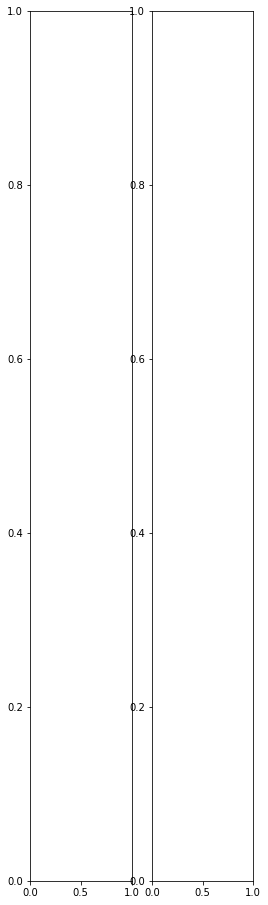

In [61]:
def plot_history(history_dict):
  fig, axes = plt.subplots(nrows=len(history_dict.keys()), ncols=2, figsize=(4*len(history_dict.keys()), 16))
  for idx, model in enumerate(history_dict.keys()):
    model_history = history_dict[model].history

    loss = pd.DataFrame(np.array([model_history['loss'], model_history['val_loss']]).T, columns=['Train', 'Validation'])
    min_loss = loss['Validation'].min()
    min_loss_idx = loss['Validation'].idxmin()
    accuracy = pd.DataFrame(np.array([model_history['accuracy'], model_history['val_accuracy']]).T, columns=['Train', 'Validation'])
    max_acc = accuracy['Validation'].min()
    max_acc_idx = accuracy['Validation'].idxmin()

    sb.lineplot(data=loss, ax=axes[idx][0])
    sb.lineplot(data=accuracy, ax=axes[idx][1])

    axes[idx][0].axhline(min_loss, color='lightgray', linestyle='-')
    axes[idx][0].axvline(min_loss_idx, color='lightgray', linestyle='-')
    axes[idx][1].axhline(max_acc, color='lightgray', linestyle='-')
    axes[idx][1].axvline(max_acc_idx, color='lightgray', linestyle='-')

    axes[idx][0].set_xlabel('Epochs')
    axes[idx][1].set_xlabel('Epochs')
    axes[idx][0].set_ylabel('Loss')
    axes[idx][1].set_ylabel('Accuracy')
    axes[idx][0].set_title(f"{model} loss")
    axes[idx][1].set_title(f"{model} accuracy")

  fig.tight_layout()
  plt.show()

TypeError: ignored

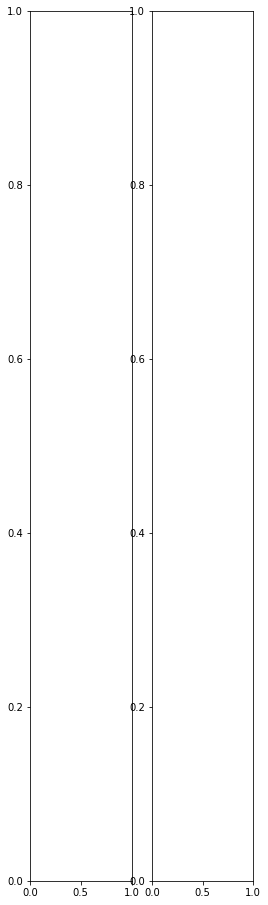

In [55]:
plot_history(history)

## Improve the model
The baseline model seems to be the best one up to this point, so we are going to try to improve its performances. 




A straightforward modification is to move to GloVe embedding with size 300, as up to now the one with size 50 has been used. This new embedding is much heavier than the previous one, but is ensures better results.

Another similar change consists in increasing LSTM hidden units, which previously were set to 100. 

Finally, since it is clear that the model starts to overfit, adding dropout might help increasing performances


In [39]:
units_bigger = 200
dropout_percentage = 0.2

In [37]:
EMBEDDING_DIMENSION_BIGGER = 300
glove_emb_model_bigger = load_GloVe_embedding(EMBEDDING_DIMENSION_BIGGER)

[==================================================] 100.0% 376.1/376.1MB downloaded


In [38]:
embedding_matrix_bigger = build_embedding_matrix(glove_emb_model_bigger, 
                                                EMBEDDING_DIMENSION_BIGGER,
                                                word_to_idx_train)
print(embedding_matrix_bigger.shape)

embedding_matrix_bigger = extend_embedding_matrix(glove_emb_model_bigger, 
                                                  embedding_matrix_bigger,
                                                  word_to_idx_val)
print(embedding_matrix_bigger.shape)

embedding_matrix_bigger = extend_embedding_matrix(glove_emb_model_bigger, 
                                                  embedding_matrix_bigger,
                                                  word_to_idx_test)
print(embedding_matrix_bigger.shape)

100%|██████████| 400318/400318 [00:01<00:00, 279066.11it/s]


(400319, 300)
(400475, 300)
(400571, 300)


In [41]:
def build_final_model(num_pos, 
                      embedding_matrix, 
                      name = 'final',
                      units = units_bigger, 
                      dropout = dropout_percentage):
  inputs = Input(shape=(None,), dtype="int32")
  
  m = Embedding(input_dim=embedding_matrix.shape[0], 
                output_dim=embedding_matrix.shape[1],
                mask_zero=True, 
                weights=[embedding_matrix], 
                trainable=False)(inputs)

  m = Bidirectional(LSTM(units=units, return_sequences=True, dropout=dropout))(m)

  m = Dense(num_pos, activation='softmax')(m)
  return Model(inputs, m, name=name)

In [42]:
models['final'] = build_final_model(num_pos = number_pos, 
                                embedding_matrix = embedding_matrix_bigger, 
                                name = "final",
                                units = units_bigger,
                                dropout = dropout_percentage) 


In [44]:
models['final'].summary()

Model: "final"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 300)         120171300 
                                                                 
 bidirectional (Bidirectiona  (None, None, 400)        801600    
 l)                                                              
                                                                 
 dense (Dense)               (None, None, 46)          18446     
                                                                 
Total params: 120,991,346
Trainable params: 820,046
Non-trainable params: 120,171,300
_________________________________________________________________


In [45]:
models['final'].compile(optimizer ='adam', 
                           loss = 'categorical_crossentropy', 
                           metrics = ['accuracy'])
history['final'] = models['final'].fit(x=x_st["train"], 
                   y=y_cat["train"], 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   validation_data=(x_st["val"], y_cat["val"]))

Epoch 1/30
197/197 [==============================] - 18s 32ms/step - loss: 0.1185 - accuracy: 0.6797 - val_loss: 0.1758 - val_accuracy: 0.8336
Epoch 2/30
197/197 [==============================] - 4s 18ms/step - loss: 0.0462 - accuracy: 0.8642 - val_loss: 0.1305 - val_accuracy: 0.8726
Epoch 3/30
197/197 [==============================] - 4s 18ms/step - loss: 0.0350 - accuracy: 0.8928 - val_loss: 0.1137 - val_accuracy: 0.8866
Epoch 4/30
197/197 [==============================] - 4s 18ms/step - loss: 0.0283 - accuracy: 0.9139 - val_loss: 0.1033 - val_accuracy: 0.8932
Epoch 5/30
197/197 [==============================] - 4s 18ms/step - loss: 0.0233 - accuracy: 0.9279 - val_loss: 0.0942 - val_accuracy: 0.9049
Epoch 6/30
197/197 [==============================] - 4s 19ms/step - loss: 0.0189 - accuracy: 0.9433 - val_loss: 0.0886 - val_accuracy: 0.9064
Epoch 7/30
197/197 [==============================] - 4s 19ms/step - loss: 0.0155 - accuracy: 0.9541 - val_loss: 0.0857 - val_accuracy: 0.910

In [48]:
f1_scores["final"] = compute_f1(models["final"],x_st["val"],y_cat["val"],punctuation_enc)
f1_scores["final"]

41/41 [==============================] - 0s 8ms/step


0.8011831453145386

In [63]:
f1_scores_test = {}

In [64]:
f1_scores_test["final"] = compute_f1(models["final"],x_st["test"],y_cat["test"],punctuation_enc)
f1_scores_test["final"]

21/21 [==============================] - 0s 8ms/step


0.8515409177582665